# Data Analytics - final project
### Norbert Sak and Adam Sygut

In [1]:
import cmdstanpy
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *

# Problem statement 

In the project we modeled the relationship between the amount of sugar and calories in cereals.

The main point to create this model is to investigate the relationship between sugars and calories in cereals. Potenial use case is for example estimate the amount of sugars knowing the number of calories.

Dataset was collected from https://www.kaggle.com/datasets/crawford/80-cereals?select=cereal.csv.
<br>It contains nutrition values (like protein, fat, sugars and much more) of 77 different types of cereals.

# Data preprocessing

In [3]:
df = pd.read_csv('cereal.csv', index_col=0)

In [4]:
df.head()

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating;;
100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973;;
100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679;;
All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505;;
All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912;;
Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843;;


Those nutrition values are defined as per serving where serving size is gien in 'weight' table in ounces. So we decided to scale it to have values for 1 ounce in every row.

In [5]:
df['sugars'] = df['sugars']/df['weight']
df['calories'] = df['calories']/df['weight']

In [6]:
df.head()

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating;;
100% Bran,N,C,70.0,4,1,130,10.0,5.0,6.0,280,25,3,1.0,0.33,68.402973;;
100% Natural Bran,Q,C,120.0,3,5,15,2.0,8.0,8.0,135,0,3,1.0,1.00,33.983679;;
All-Bran,K,C,70.0,4,1,260,9.0,7.0,5.0,320,25,3,1.0,0.33,59.425505;;
All-Bran with Extra Fiber,K,C,50.0,4,0,140,14.0,8.0,0.0,330,25,3,1.0,0.50,93.704912;;
Almond Delight,R,C,110.0,2,2,200,1.0,14.0,8.0,-1,25,3,1.0,0.75,34.384843;;


Histogram of calories

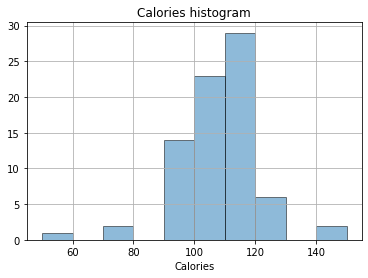

In [7]:
df['calories'].hist(alpha=0.5, ec='black')
plt.title('Calories histogram')
plt.xlabel('Calories')
plt.show()

Histogram of sugars

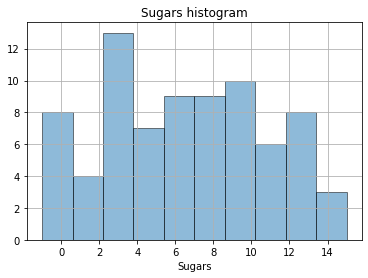

In [8]:
df['sugars'].hist(alpha=0.5, ec='black')
plt.title('Sugars histogram')
plt.xlabel('Sugars')
plt.show()

Creation of dataframe with values that we need (calories and sugars).

In [9]:
data = df[['calories' ,'sugars']]

In [10]:
data

,calories,sugars
100% Bran,70.0,6.0
100% Natural Bran,120.0,8.0
All-Bran,70.0,5.0
All-Bran with Extra Fiber,50.0,0.0
Almond Delight,110.0,8.0
...,...,...
Triples,110.0,3.0
Trix,110.0,12.0
Wheat Chex,100.0,3.0
Wheaties,100.0,3.0


Next we've checked if all values are reasonable.

In [11]:
data['calories'].value_counts()

110.000000    29
100.000000    19
90.000000      7
120.000000     6
90.225564      3
70.000000      2
150.000000     2
50.000000      1
97.744361      1
96.000000      1
107.692308     1
106.666667     1
105.263158     1
104.000000     1
96.385542      1
93.333333      1
Name: calories, dtype: int64

In [12]:
data['sugars'].value_counts()

 3.000000     13
 0.000000      7
 6.000000      7
 8.000000      6
 5.000000      5
 11.000000     5
 12.000000     5
 7.000000      3
 10.000000     3
 13.000000     3
 2.000000      3
 9.000000      3
 9.022556      2
 15.000000     2
 1.000000      1
 6.015038      1
 14.000000     1
 4.000000      1
 6.923077      1
 8.666667      1
 5.263158      1
 10.526316     1
-1.000000      1
 9.333333      1
Name: sugars, dtype: int64

We've found that in sugars we have value of -1 which is an absurd. So we've decided to remove it.

In [13]:
data = data.drop(data[data['sugars'] == -1].index)

Dataframe statistics.

In [14]:
data.describe()

,calories,sugars
count,76.000000,76.000000
mean,104.049501,6.654904
std,13.936164,4.093540
min,50.000000,0.000000
25%,100.000000,3.000000
50%,107.179487,6.007519
75%,110.000000,10.000000
max,150.000000,15.000000


# Models in project

### 1. Model using normal distribution

#### 1.1 Model based only on calories
In our project we decided to start with simple model based only on calories.

#### 1.2 Model with sugars as predictor 
Next, we decided to add sugars as predictor. Calories will be now defined in the model as:
<br><br>
$calories_{i}\sim Normal(\mu _{i}, \sigma )$
<br><br>
$\mu _{i}=\alpha + \beta *sugars_{i}$
<br><br>
Where $\alpha$ and $\beta$ have normal distribution and $\sigma$ has exponential distribution.

### 2. Model using double exponential distribution
In the second model we decided to use double exponential distribution instead of normal distribution beacuse as we can see on calories histogram values of calories in our dataset are stacked in the middle of the histogram and we thought that it will fit our data better than normal distribution.
<br><br>
$calories_{i}\sim DoubleExponential(\mu _{i}, \sigma )$
<br><br>
$\mu _{i}=\alpha + \beta *sugars_{i}$
<br><br>
Where $\alpha$ and $\beta$ have normal distribution and $\sigma$ has exponential distribution.

<h1>1. Model using normal distribution</h1>

## 1.1
In the first model we've considered only calories and used normal distribution.

## Normal distribution

$$
Normal(y|\mu ,\sigma )=\frac{1}{\sqrt{2\pi}\sigma}exp\left ( -\frac{1}{2} \left ( \frac{y-\mu}{\sigma} \right )^{2} \right )
$$

## Prior predictive check

Prior values were chosen based on https://kalkulatorkalorii.net/ webpage. We've checked few types of cereals that we know.
Based on those values we picked values for priors, we set the value of mu to be normally distributed with mean of 105 and standard deviation of 15.

The value of sigma was set to be exponentially distributed with inverse scale beta of 0.067 (because $\frac{1}{15}\approx 0.067$).

In [15]:
with open('cereal_1_ppc.stan') as file:
    print(file.read())

generated quantities {
   real mu = normal_rng(105, 15);
   real sigma = exponential_rng(0.067);
   real calories = normal_rng(mu, sigma);
}


In [16]:
model_ppc=cmdstanpy.CmdStanModel(stan_file='cereal_1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [17]:
R = 1000
sim = model_ppc.sample(iter_sampling=R, iter_warmup=0, chains=1, fixed_param=True, seed=12062022, refresh=R, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [18]:
mu_sim=sim.stan_variable('mu')
sigma_sim=sim.stan_variable('sigma')
calories_sim=sim.stan_variable('calories')

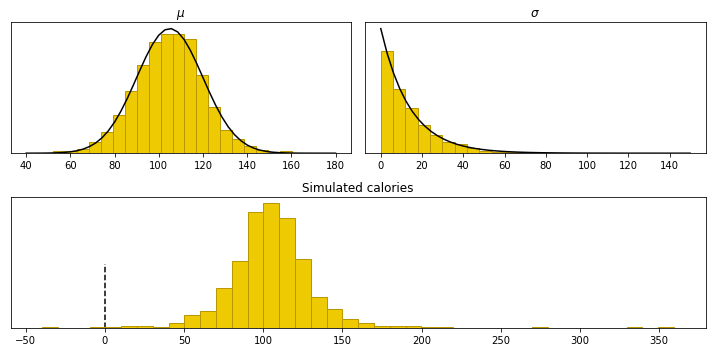

In [19]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[1,:])
ax1.vlines([0], ymin=0, ymax=1e-2, linestyle='--',color='black', zorder=1)
ax1.hist(calories_sim, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)

ax1.set_yticks([])
ax1.set_title('Simulated calories')

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])

ax2.hist(mu_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(40,180)
y=stats.norm.pdf(x,loc=105,scale=15)
ax2.plot(x,y,'black')
ax3.set_title('$\sigma$')
ax2.set_title('$\mu$')
ax2.set_yticks([])
ax3.set_yticks([])
ax3.hist(sigma_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(0,150)
y=stats.expon.pdf(x,scale=14)
ax3.plot(x,y,'black')

fig.tight_layout()
plt.show()

As we can see simulated values of parameters $\mu$ and $\sigma$ were distributed well, as we expected.
<br>Values of simulated calories are mostly distributed well (the mean is distributed were we expected) but we have some outliers which, when we add some data, will probably dissapear.

## Posterior analysis

In [20]:
with open('cereal_1_fit.stan') as file:
    print(file.read())

data {
   int N;
   real calories[N];
}

parameters {
   real mu;
   real<lower=0> sigma;
}

model {
   mu ~ normal(105, 15);
   sigma ~ exponential(0.067);
   calories ~ normal(mu, sigma);
}

generated quantities {
   real log_lik = normal_lpdf(calories | mu, sigma);
   real calorie = normal_rng(mu, sigma);
}


Data required for this model:
 - N -> calories vector size
 - calories -> calories vector 

In [21]:
model_1_fit=cmdstanpy.CmdStanModel(stan_file='cereal_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [22]:
fit_1=model_1_fit.sample(data=dict(N=len(data['calories']), calories=data['calories'].values), seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [23]:
print(fit_1.diagnose())

Processing csv files: C:\GitHub\DataAnalyticsProject\Project\samples\cereal_1_fit-20220621230846_1.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_1_fit-20220621230846_2.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_1_fit-20220621230846_3.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_1_fit-20220621230846_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



No errors/issues occured during sampling.

In [24]:
az.summary(fit_1, var_names=['mu', 'sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,104.11,1.59,101.02,107.00
sigma,14.09,1.18,11.90,16.33


Values of mu and sigma are very close to those proposed by us in ppc.

In [25]:
mu_fit = fit_1.stan_variable('mu')
sigma_fit = fit_1.stan_variable('sigma')
calorie_pred = fit_1.stan_variable('calorie')

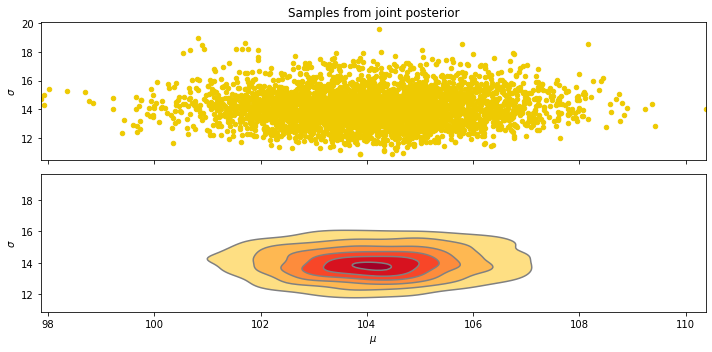

In [26]:
fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True)
ax1=axes[0]
ax1.scatter(mu_fit, sigma_fit, 20, color=DARK)
ax1.set_title("Samples from joint posterior")
ax1.set_ylabel(r'$\sigma$')
ax2=axes[1]
az.plot_kde(mu_fit, sigma_fit, ax=ax2, contourf_kwargs={'cmap':'YlOrRd'})

ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$')
fig.tight_layout()
plt.show()

As we can see our sigma and mu samples from joint posterior are concenrated.

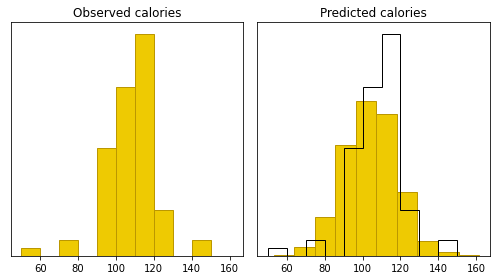

In [27]:
fig, axes = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(data['calories'], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed calories')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(calorie_pred, bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(data['calories'], bins=10, histtype='step', color='black', density=True)

ax2.set_title('Predicted calories')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

Outliers observed during ppc dissapeared as we expected.<br>
As we can see samples for posterior predictive did not match exactly the observed values. Observed values are more clustered close to the mean value.
<br>Data is not exactly similar with posterior predicitve sample but it's quite close.

<h1>1.2</h1>

We've decided to add predictor - value of sugars.

<br>Those values were centered to represent sugars not as grams but the difference from the mean. It was added to dataframe as 'c_sugars'.
<br>

$calories_{i}\sim Normal(\mu _{i}, \sigma )$
<br><br>

$\mu _{i}=\alpha + \beta *c\_sugars_{i}$
<br><br>

Where $\alpha$ and $\beta$ have normal distribution and $\sigma$ has exponential distribution.

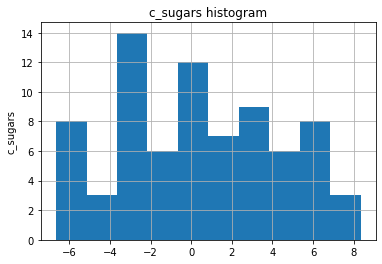

In [28]:
data['c_sugars'] = data['sugars']-data['sugars'].mean()
data['c_sugars'].hist()
plt.ylabel('c_sugars')
plt.title('c_sugars histogram')
plt.show()

## Prior predictive check

We used the same values for alpha and sigma as for mu and sigma in previous prior. The value of beta was set to be normally distriuted with mean of 0 and std of 10.

In [29]:
with open('cereal_2a_ppc.stan') as file:
    print(file.read())

data {
   int N;
   real sugars[N];
}

generated quantities {
   real alpha = normal_rng(105, 15);
   real beta = normal_rng(0, 10);
   real sigma = exponential_rng(0.067);
   real calorie[N];
   for (i in 1:N) {
      calorie[i] = normal_rng(sugars[i]*beta+alpha, sigma);
   }

}


In [30]:
model_ppc = cmdstanpy.CmdStanModel(stan_file='cereal_2a_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [31]:
R = 1000
data_sim = {'N': len(data), 'sugars':np.linspace(data['c_sugars'].min(),data['c_sugars'].max(), num=len(data))}

sim = model_ppc.sample(data=data_sim,iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [32]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')

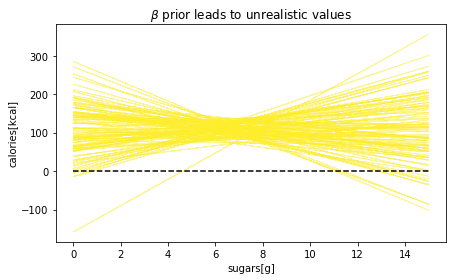

In [33]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

for i in range(100):
    axes.plot(data['sugars'], alpha_sim[i]+beta_sim[i]*data['c_sugars'], color=MID, alpha=0.5, linewidth = 0.5)
axes.set_xlabel('sugars[g]')
axes.set_ylabel('calories[kcal]')
axes.set_title(r"$\beta$ prior leads to unrealistic values")
axes.hlines([0],xmin=data['sugars'].min(), xmax=data['sugars'].max(), linestyle='--', color='black')
plt.show()

As we can see simulated data using normal distribution for beta leads to some unrealistic values so we decided to change its distribution to lognormal with mu 0 and sigma 1. Lognormal was used beacuse in generall in can ensure that the values will be positive. 

In [34]:
with open('cereal_2b_ppc.stan') as file:
    print(file.read())

data {
   int N;
   real sugars[N];
}

generated quantities {
   real alpha = normal_rng(105, 15);
   real beta = lognormal_rng(0, 1);
   real sigma = exponential_rng(0.067);
   real calorie[N];
   for (i in 1:N) {
      calorie[i] = normal_rng(sugars[i]*beta+alpha, sigma);
   }

}


In [35]:
model_ppc = cmdstanpy.CmdStanModel(stan_file='cereal_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [36]:
sim = model_ppc.sample(data=data_sim,iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [37]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')

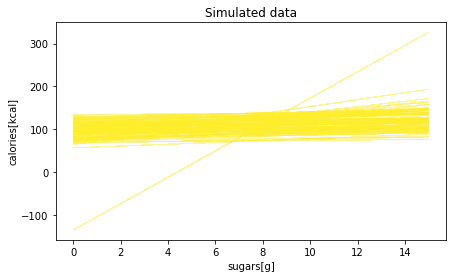

In [38]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

for i in range(100):
    axes.plot(data['sugars'], alpha_sim[i]+beta_sim[i]*data['c_sugars'], color=MID, alpha=0.5, linewidth = 0.5)

axes.set_xlabel('sugars[g]')
axes.set_ylabel('calories[kcal]')
axes.set_title("Simulated data")
plt.show()

Our simulated data is mostly from 60 to 140. There is one line that leads to some unrealistic values but generally it is quite well.

In [39]:
calorie_sim = sim.stan_variable('calorie')

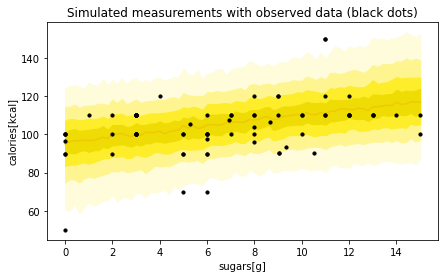

In [40]:
fig, axes = plt.subplots(1,1,figsize = (7,4))
axes=ribbon_plot(data_sim['sugars']+data['sugars'].mean(),calorie_sim,axes)
axes.scatter(data['sugars'], data['calories'], color = 'black', alpha = 1, s=10)
axes.set_xlabel('sugars[g]')
axes.set_ylabel('calories[kcal]')
axes.set_title("Simulated measurements with observed data (black dots)")
plt.show()

As we can see observed data is well fitted inside data simulated from our model. There are 2 points that are outside of this area but they are still quite close.

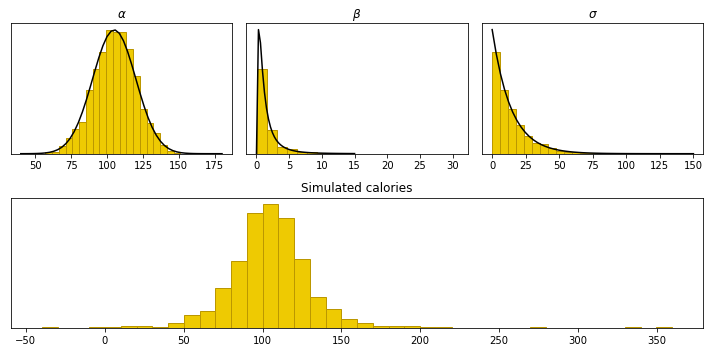

In [41]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[1,:])
ax1.hist(calories_sim, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)

ax1.set_yticks([])
ax1.set_title('Simulated calories')

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[0, 2])

ax2.hist(alpha_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(40,180)
y=stats.norm.pdf(x,loc=105,scale=15)
ax2.plot(x,y,'black')
ax4.set_title('$\sigma$')
ax2.set_title(r'$\alpha$')
ax2.set_yticks([])
ax4.set_yticks([])
ax4.hist(sigma_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(0,150)
y=stats.expon.pdf(x,scale=14)
ax4.plot(x,y,'black')


ax3.hist(beta_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(0,15)
y=stats.lognorm.pdf(x, s=1)
ax3.plot(x,y,'black')
ax3.set_title(r'$\beta$')
ax3.set_yticks([])

fig.tight_layout()
plt.show()

As we can see simulated values of parameters $\alpha$, $\beta$ ans $\sigma$ were distributed well, as we expected.
<br>Values of simulated calories are mostly distributed well (the mean is distributed were we expected) but we have some outliers which, when we add some data, will probably dissapear.

# Posterior

In [42]:
with open('cereal_2_fit.stan') as file:
    print(file.read())

data {
   int N;
   vector[N] sugars;
   real calories[N];
}

parameters {
   real alpha;
   real beta;
   real<lower=0> sigma;
}

transformed parameters {
   vector[N] mu = sugars*beta+alpha;
}

model {
   alpha ~ normal(105, 15);
   beta ~ lognormal(0, 1);
   sigma ~ exponential(0.067);
   calories ~ normal(mu, sigma);
}

generated quantities {
   vector[N] log_lik;
   real calorie[N];
   for (i in 1:N) {
      log_lik[i] = normal_lpdf(calories[i] | mu[i], sigma);
      calorie[i] = normal_rng(mu[i], sigma);
   }
}


Data required for this model:
 - N -> calories vector size
 - sugars -> sugars vector
 - calories -> calories vector

In [43]:
model_2_fit = cmdstanpy.CmdStanModel(stan_file='cereal_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [44]:
data_fit = dict(N=len(data),
                sugars=data['c_sugars'].values,
                calories=data['calories'].values)

fit_2=model_2_fit.sample(data=data_fit, seed=12062022, output_dir='samples', adapt_delta=0.999)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


When first running diagnose() we discovered the following issue.

"""Checking sampler transitions for divergences.
10 of 4000 (0.25%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model."""

We decide to changed "adapt_delta" parameter from 0.8 to 0.999. After this change issue was resolved.

In [45]:
print(fit_2.diagnose())

Processing csv files: C:\GitHub\DataAnalyticsProject\Project\samples\cereal_2_fit-20220621230907_1.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_2_fit-20220621230907_2.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_2_fit-20220621230907_3.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_2_fit-20220621230907_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [46]:
alpha_fit = fit_2.stan_variable('alpha')
beta_fit = fit_2.stan_variable('beta')
mu_fit = fit_2.stan_variable('mu')
sigma_fit = fit_2.stan_variable('sigma')
calorie_pred = fit_2.stan_variable('calorie')

In [47]:
az.summary(fit_2, var_names=['alpha', 'beta', 'sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,104.01,1.52,101.08,106.68
beta,1.16,0.36,0.51,1.85
sigma,13.12,1.08,11.11,15.12


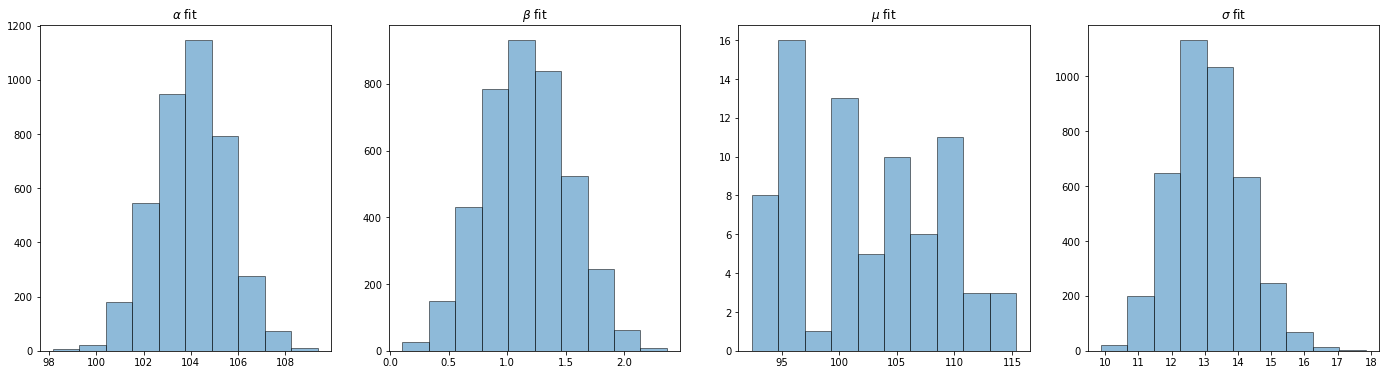

In [48]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (24,6))

ax1.hist(alpha_fit, alpha=0.5, ec='black')
ax1.set_title(r"$\alpha$ fit")
ax2.hist(beta_fit, alpha=0.5, ec='black')
ax2.set_title(r"$\beta$ fit")
ax3.hist(mu_fit[0], alpha=0.5, ec='black')
ax3.set_title(r"$\mu$ fit")
ax4.hist(sigma_fit, alpha=0.5, ec='black')
ax4.set_title(r"$\sigma$ fit")
plt.show()

$\alpha$ values are normally distributed with values from 98 to 110 with mean somewhere around 105. <br>
$\beta$ values are normally distributed with values from 0 to 2.5 with mean somewhere around 1. <br>
$\mu$ values are from 90 to 115. <br>
$\sigma$ values are exponentialy distributed with values from 10 to 18 with mean somewhere around 13. <br>

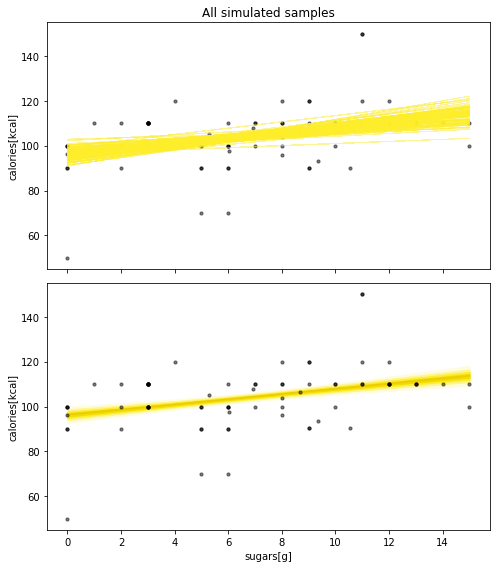

In [49]:
fig, axes = plt.subplots(2,1,figsize = (7,8), sharey=True, sharex=True)
ax0=axes[0]

for i in range(100):
    ax0.plot(data['sugars'],
            alpha_fit[i]+beta_fit[i]*data['c_sugars'],
            color=MID,
            alpha=0.5, linewidth=0.5)

ax0.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)

ax1=axes[1]
ax1=ribbon_plot(data['sugars'].values, mu_fit, ax1, supress_warning=True)
ax1.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)
ax1.set_xlabel('sugars[g]')
ax1.set_ylabel('calories[kcal]')
ax0.set_ylabel('calories[kcal]')
ax0.set_title("All simulated samples")
fig.tight_layout()
plt.show()

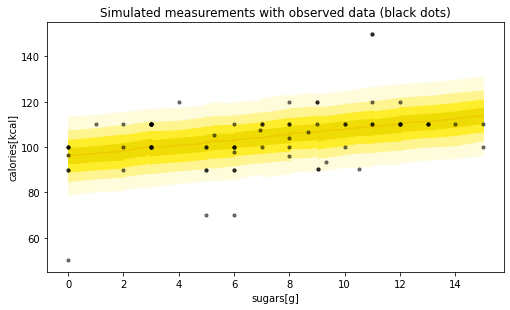

In [50]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

axes=ribbon_plot(data['sugars'].values, calorie_pred, axes, supress_warning=True)
axes.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)
fig.tight_layout()
axes.set_xlabel('sugars[g]')
axes.set_ylabel('calories[kcal]')
axes.set_title("Simulated measurements with observed data (black dots)")
plt.show()

As we can see observed data is generally well fitted inside data simulated from our model. There are some points that are outside of this area.

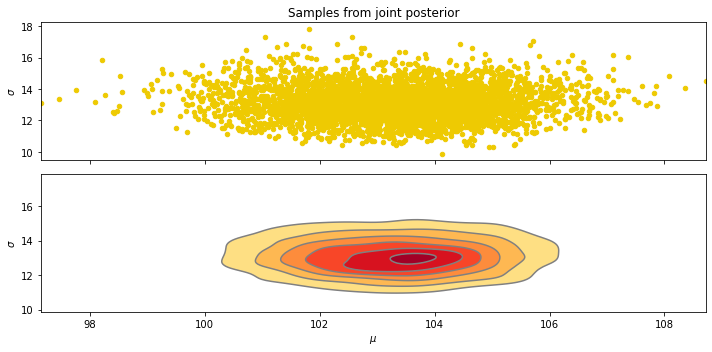

In [51]:
fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True)
ax1=axes[0]
ax1.scatter(mu_fit[:,0], sigma_fit, 20, color=DARK)
ax1.set_title("Samples from joint posterior")
ax1.set_ylabel(r'$\sigma$')
ax2=axes[1]
az.plot_kde(mu_fit[:,0], sigma_fit, ax=ax2, contourf_kwargs={'cmap':'YlOrRd'})

ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$')
fig.tight_layout()
plt.show()

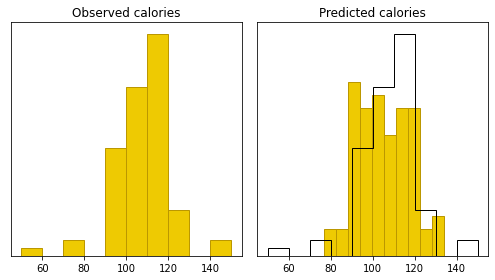

In [52]:
fig, axes = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(data['calories'], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed calories')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(calorie_pred[3000], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(data['calories'], bins=10, histtype='step', color='black', density=True)

ax2.set_title('Predicted calories')
ax2.set_yticks(())
fig.tight_layout()

plt.show()

In comparison with 1.1 model values are more squeezed (previously from 60 to 160, now somewhere from 80 to 130). <br>
As we can see our model has problem with catching values stacked in the middle so we decided to use double exponential distribution because we thought it will solve this issue.

In [53]:
fit_id_1 = az.from_cmdstanpy(posterior=fit_2,log_likelihood='log_lik')

In [54]:
fit_id_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

# Model 2

## Double Exponential (Laplace) Distribution
$$
DoubleExponential(y|\mu ,\sigma )=\frac{1}{2\sigma}exp\left ( -\frac{\left | y-\mu \right |}{\sigma} \right )
$$

# Prior predictive check

We used the same values for alpha, beta and sigma as the in previous prior. We only changed the distribution from normal distribution to double exponential distribution.

In [55]:
with open('cereal_3_ppc.stan') as file:
    print(file.read())

data {
   int N;
   real sugars[N];
}

generated quantities {
   real alpha = double_exponential_rng(105, 15);
   real beta = lognormal_rng(0, 1);
   real sigma = exponential_rng(0.067);
   real calorie[N];
   for (i in 1:N) {
      calorie[i] = double_exponential_rng(sugars[i]*beta+alpha, sigma);
   }

}


In [56]:
model_ppc = cmdstanpy.CmdStanModel(stan_file='cereal_3_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [57]:
sim = model_ppc.sample(data=data_sim,iter_sampling=R, iter_warmup=0, chains=1, refresh=R, fixed_param=True, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [58]:
alpha_sim = sim.stan_variable('alpha')
beta_sim = sim.stan_variable('beta')
sigma_sim = sim.stan_variable('sigma')
calories_sim=sim.stan_variable('calorie')

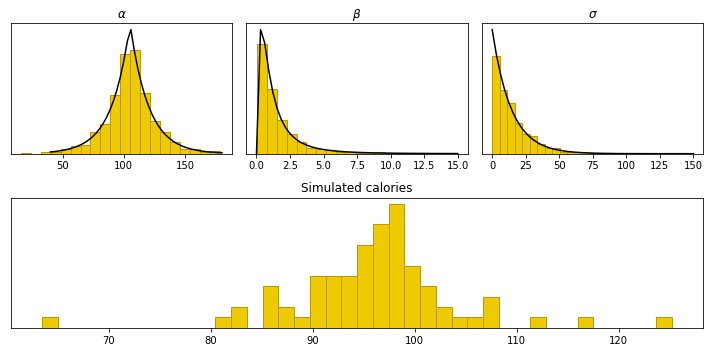

In [59]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[1,:])
ax1.hist(calories_sim[579], bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)

ax1.set_yticks([])
ax1.set_title('Simulated calories')

ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[0, 2])

ax2.hist(alpha_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(40,180)
y=stats.laplace.pdf(x,loc=105,scale=15)
ax2.plot(x,y,'black')
ax4.set_title('$\sigma$')
ax2.set_title(r'$\alpha$')
ax2.set_yticks([])
ax4.set_yticks([])
ax4.hist(sigma_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(0,150)
y=stats.expon.pdf(x,scale=14)
ax4.plot(x,y,'black')


ax3.hist(beta_sim, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT,density=True)
x=np.linspace(0,15)
y=stats.lognorm.pdf(x, s=1)
ax3.plot(x,y,'black')
ax3.set_title(r'$\beta$')
ax3.set_yticks([])

fig.tight_layout()
plt.show()

As we can see simulated values of parameters $\alpha$, $\beta$ ans $\sigma$ were distributed well, as we expected.
<br>Values of simulated calories are mostly distributed well. In contrast to exmaples in 1.1 and 1.2, there are no outliers like minus values or very high values. 

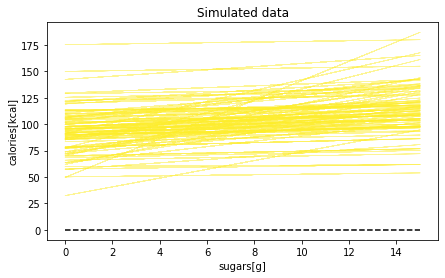

In [60]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

for i in range(100):
    axes.plot(data['sugars'], alpha_sim[i]+beta_sim[i]*data['c_sugars'], color=MID, alpha=0.5, linewidth = 0.5)
axes.set_xlabel('sugars[g]')
axes.set_ylabel('calories[kcal]')

axes.hlines([0],xmin=data['sugars'].min(), xmax=data['sugars'].max(), linestyle='--', color='black')
axes.set_title("Simulated data")
plt.show()

Our simulated data is mostly from 50 to 150. There is no line that leads to unrealistic values like in 1.2.

In [61]:
calorie_sim = sim.stan_variable('calorie')

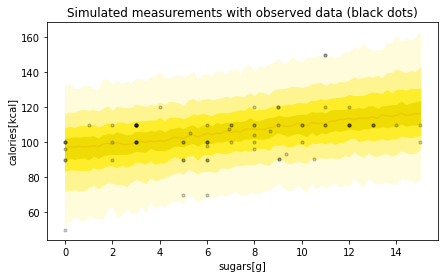

In [62]:
fig, axes = plt.subplots(1,1,figsize = (7,4))
axes=ribbon_plot(data_sim['sugars']+data['sugars'].mean(),calorie_sim,axes)
axes.scatter(data['sugars'], data['calories'], color = 'black', alpha = 0.2, s=10)
axes.set_xlabel('sugars[g]')
axes.set_ylabel('calories[kcal]')
axes.set_title("Simulated measurements with observed data (black dots)")
plt.show()

As we can see observed data is well fitted inside data simulated from our model.

# Posterior

In [63]:
with open('cereal_3_fit.stan') as file:
    print(file.read())

data {
   int N;
   vector[N] sugars;
   vector[N] calories;
}

parameters {
   real alpha;
   real beta;
   real<lower=0> sigma;
}

transformed parameters {
   vector[N] mu = sugars*beta+alpha;
}

model {
   alpha ~ double_exponential(105, 15);
   beta ~ lognormal(0, 1);
   sigma ~ exponential(0.067);
   calories ~ double_exponential(mu, sigma);
}

generated quantities {
   vector[N] log_lik;
   real calorie[N];
   for (i in 1:N) {
      log_lik[i] = double_exponential_lpdf(calories[i] | mu[i], sigma);
      calorie[i] = double_exponential_rng(mu[i], sigma);
   }
}


Data required for this model:
 - N -> size of calories vector
 - sugars -> sugars vector
 - calories -> calories vector

In [64]:
model_3_fit = cmdstanpy.CmdStanModel(stan_file='cereal_3_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [65]:
data_fit = dict(N=len(data),
                sugars=data['c_sugars'].values,
                calories=data['calories'].values)

fit_3=model_3_fit.sample(data=data_fit, seed=12062022, output_dir='samples')

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [66]:
print(fit_3.diagnose())

Processing csv files: C:\GitHub\DataAnalyticsProject\Project\samples\cereal_3_fit-20220621230936_1.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_3_fit-20220621230936_2.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_3_fit-20220621230936_3.csv, C:\GitHub\DataAnalyticsProject\Project\samples\cereal_3_fit-20220621230936_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



No errors/issues occured during sampling.

In [67]:
az.summary(fit_3, var_names=['alpha', 'beta', 'sigma'], round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,104.68,0.97,102.93,106.54
beta,0.90,0.19,0.58,1.28
sigma,8.77,1.00,6.93,10.63


Comaring to 1.2 model mean values of beta and sigma decrease (beta from 1.16 to 0.9 and sigma from 13.12 to 8.77). Mean alpha value is similar.

In [68]:
alpha_fit = fit_3.stan_variable('alpha')
beta_fit = fit_3.stan_variable('beta')
mu_fit = fit_3.stan_variable('mu')
sigma_fit = fit_3.stan_variable('sigma')
calorie_pred = fit_3.stan_variable('calorie')

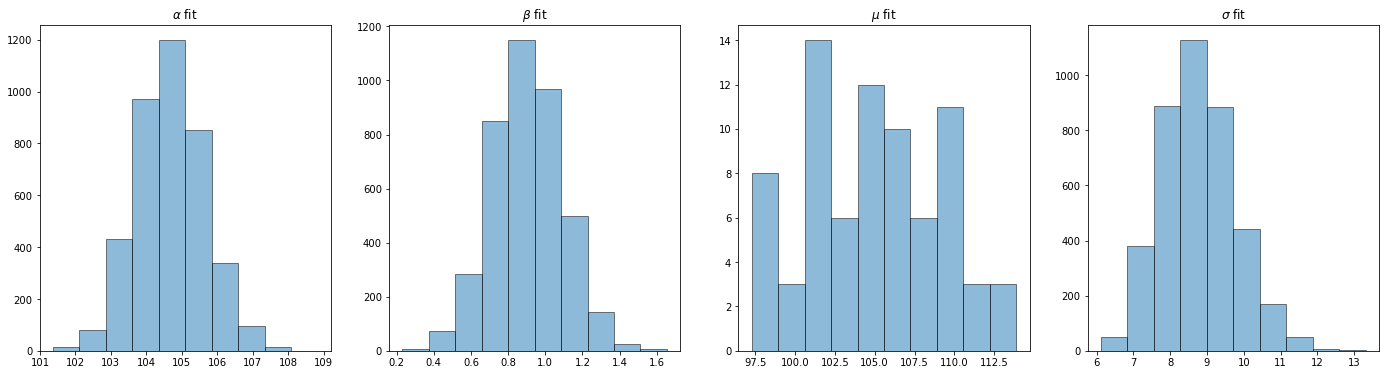

In [69]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (24,6))

ax1.hist(alpha_fit, alpha=0.5, ec='black')
ax1.set_title(r"$\alpha$ fit")
ax2.hist(beta_fit, alpha=0.5, ec='black')
ax2.set_title(r"$\beta$ fit")
ax3.hist(mu_fit[0], alpha=0.5, ec='black')
ax3.set_title(r"$\mu$ fit")
ax4.hist(sigma_fit, alpha=0.5, ec='black')
ax4.set_title(r"$\sigma$ fit")
plt.show()

$\alpha$ values are normally distributed with values from 100 to 108 with mean somewhere around 105. <br>
$\beta$ values are normally distributed with values from 0 to 1.6 with mean somewhere around 0.9. <br>
$\mu$ values are from 97.5 to 113. <br>
$\sigma$ values are exponentialy distributed with values from 6 to 13 with mean somewhere around 8.5. <br>

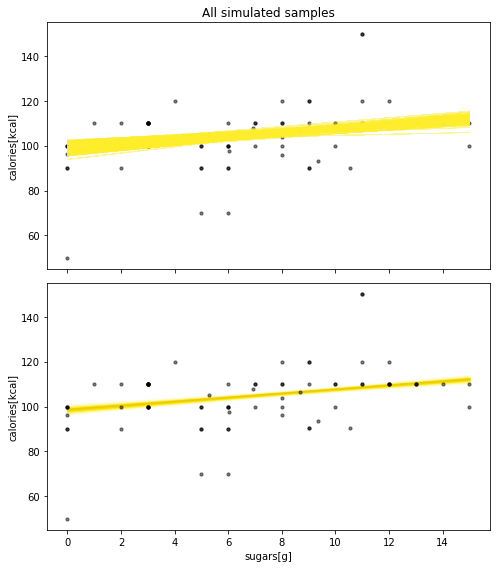

In [70]:
fig, axes = plt.subplots(2,1,figsize = (7,8), sharey=True, sharex=True)
ax0=axes[0]

for i in range(100):
    ax0.plot(data['sugars'],
            alpha_fit[i]+beta_fit[i]*data['c_sugars'],
            color=MID,
            alpha=0.5, linewidth=0.5)

ax0.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)

ax1=axes[1]
ax1=ribbon_plot(data['sugars'].values, mu_fit, ax1, supress_warning=True)
ax1.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)
ax1.set_xlabel('sugars[g]')
ax1.set_ylabel('calories[kcal]')
ax0.set_ylabel('calories[kcal]')
ax0.set_title("All simulated samples")
fig.tight_layout()
plt.show()

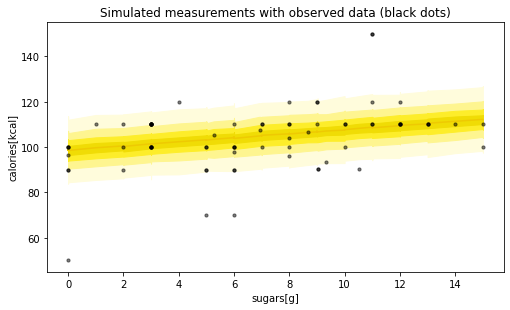

In [71]:
fig, axes = plt.subplots(1,1,figsize = (7,4))

axes=ribbon_plot(data['sugars'].values, calorie_pred, axes, supress_warning=True)
axes.scatter(data['sugars'], data['calories'], color='black', alpha=0.5, s=10)
fig.tight_layout()
axes.set_xlabel('sugars[g]')
axes.set_ylabel('calories[kcal]')
axes.set_title("Simulated measurements with observed data (black dots)")
plt.show()

As we can see observed data is generally well fitted inside data simulated from our model. There are some points that are outside of this area.

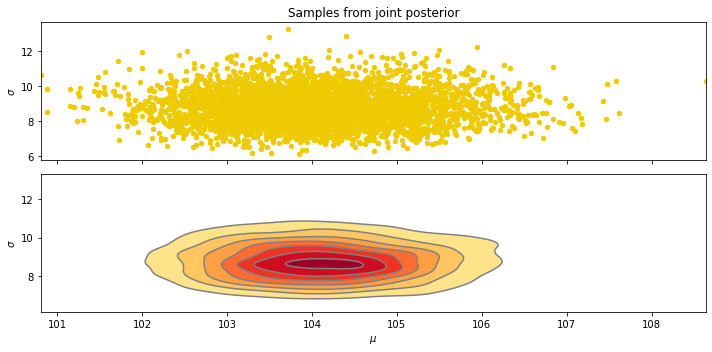

In [72]:
fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True)
ax1=axes[0]
ax1.scatter(mu_fit[:,0], sigma_fit, 20, color=DARK)
ax1.set_title("Samples from joint posterior")
ax1.set_ylabel(r'$\sigma$')
ax2=axes[1]
az.plot_kde(mu_fit[:,0], sigma_fit, ax=ax2, contourf_kwargs={'cmap':'YlOrRd'})

ax2.set_xlabel(r'$\mu$')
ax2.set_ylabel(r'$\sigma$')
fig.tight_layout()
plt.show()

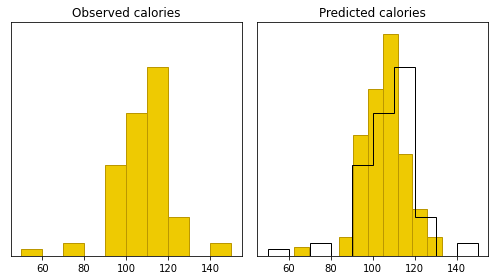

In [73]:
fig, axes = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)
ax=axes[0]
ax.hist(data['calories'], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax.set_title('Observed calories')
ax.set_yticks(())
ax2=axes[1]
ax2.hist(calorie_pred[3000], bins=10, color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
ax2.hist(data['calories'], bins=10, histtype='step', color='black', density=True)

ax2.set_title('Predicted calories')
ax2.set_yticks(())
fig.tight_layout()

As we can see now model is able to better catch values stacked in the middle.
Also values are a little bit less squeezed in compare to 1.2 model.<br>
The one thing that can be improved are boundary values (like 60, 140).

In [74]:
fit_id_2 = az.from_cmdstanpy(posterior=fit_3,log_likelihood='log_lik')

In [75]:
model_compare = az.compare({'Normal distribution model':fit_id_1,'Double exponential distribution model':fit_id_2})
model_compare

c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Double exponential distribution model,0,-293.665885,2.534442,0.000000,1.0,9.929358,0.000000,False,log
Normal distribution model,1,-305.648238,4.536610,11.982353,0.0,10.883787,3.732203,False,log


rank -> The rank-order of the models. 0 is the best - Double exponential distribution model model performes better than normal model <br>
loo -> Higher loo indicates higher out-of-sample predictive fit ("better model") - Double exponential distribution model performes better than normal model<br>
p_loo -> Estimated effective number of parameters<br>
d_loo -> The difference in loo between two models<br>
weight -> Relative weight for each model. This can be loosely interpreted as the probability of each model (among the compared model) given the data<br>
se -> Standard error of the information criteria estimate<br>
dse -> Standard error of the difference in information criteria between each model and the top-ranked model<br>
warning -> A value of 1 indicates that the computation of information criteria may not be reliable. No warnings.<br>
scale -> scale used for information criteria

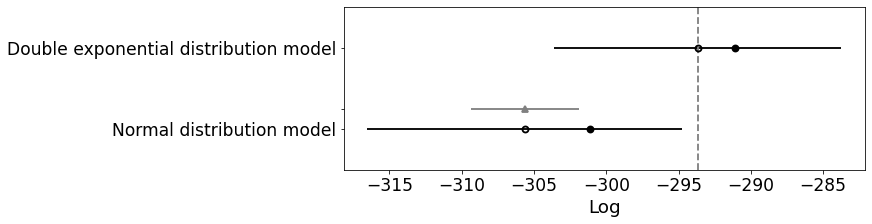

In [76]:
az.plot_compare(model_compare, figsize = (12, 3))
plt.show()

When using LOO information criteria model using Laplace distribution got better result than first model. But the results were pretty close.

In [77]:
model_compare_2 = az.compare({'Normal distribution model':fit_id_1,'Double exponential distribution model':fit_id_2}, ic='waic')
model_compare_2

c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale)])
c:\Anaconda3\envs\data_analytics\lib\site-packages\arviz\stats\stats.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Double exponential distribution model,0,-293.666491,2.535047,0.000000,1.0,9.929827,0.000000,False,log
Normal distribution model,1,-305.663557,4.551928,11.997066,0.0,10.893591,3.739875,True,log


rank -> The rank-order of the models. 0 is the best - Double exponential distribution model model performes better than normal model <br>
waic -> Higher waic indicates higher out-of-sample predictive fit ("better model") - Double exponential distribution model performes better than normal model<br>
p_waic -> Estimated effective number of parameters<br>
d_waic -> The difference in waic between two models<br>
weight -> Relative weight for each model. This can be loosely interpreted as the probability of each model (among the compared model) given the data<br>
se -> Standard error of the information criteria estimate<br>
dse -> Standard error of the difference in information criteria between each model and the top-ranked model<br>
warning -> A value of 1 indicates that the computation of information criteria may not be reliable. Warning in "Normal distribution model" (For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail.).<br>
scale -> scale used for information criteria

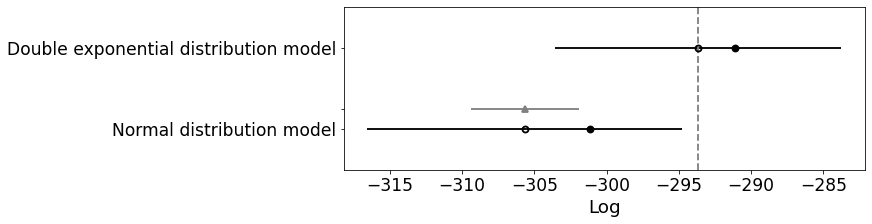

In [78]:
az.plot_compare(model_compare_2, figsize = (12, 3))
plt.show()

When using WAIC information criteria again model using Laplace distribution got better result than first model.  But the results were pretty close.

Reults of comparing models using WAIC and LOO information criteria were almost the same.

In our opinion second model (using double exponential distribution) performed a little bit better than the fisrt one beacuse it was able to better catch values stacked close to the mean value.